In [1]:
import os
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import cv2

# Folders

In [2]:
ds_dir = 'ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['labels.cache', 'labels', 'labels_2.cache', 'images']


# Config

In [3]:
CLASSES = ["smoke", "fire"]
#CLASSES = ["cat", "dog"]

IMG_DIM = {'W':88, 'H':88} # (W, H)
#IMG_DIM = {'W':160, 'H':120} # (W, H)
#IMG_DIM = {'W':448, 'H':448} # (W, H)
#IMG_DIM = {'W':224, 'H':224} # (W, H)

SX = 4
SY = 4
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [4]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:12]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, class_0, class_1]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:7].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 SX, SY, C, 
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.SX = SX
        self.SY = SY
        self.C = C
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_3 = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()

                    # Restrict to 3 boxes per sample
                    if len(lines) > 3:
                        more_than_3 += 1
                        continue
                    
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # smoke
                            if class_id == 0:
                                one_labels.append(0)
                            # fire
                            elif class_id == 1:
                                one_labels.append(1)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'Removed wrong images: {wrong_imgs}')
        print(f'Removed due to overlapping: {overlapping_rem}')
        print(f'Removed due to more than 3: {more_than_3}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = img / 255.
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# DFS

In [6]:
dfs_base_dir = 'ds2fire/dfs_xml/'
dfs_images_dir = dfs_base_dir + 'images/'
dfs_labels_dir = dfs_base_dir + 'labels/'


# Get all txt file paths in path_annot and sort them
dfs_xml_files = sorted(
    [
        os.path.join(dfs_labels_dir, file_name)
        for file_name in os.listdir(dfs_labels_dir)
        if file_name.endswith(".xml")
    ]
)

dfs_len = len(dfs_xml_files)
dfs_train_elements = int(dfs_len*0.8)
dfs_test_elements = dfs_len - dfs_train_elements

random.shuffle(dfs_xml_files)
dfs_train_list = dfs_xml_files[:dfs_train_elements]
dfs_test_list = dfs_xml_files[dfs_train_elements:]

print(f'DFS number of samples: {dfs_len}')
print(f'DFS train samples: {len(dfs_train_list)}')
print(f'DFS test samples: {len(dfs_test_list)}')


DFS number of samples: 9462
DFS train samples: 7569
DFS test samples: 1893


In [7]:
class DFSDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, labels_list, 
                 SX, SY, C, 
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.labels_list = labels_list
        self.SX = SX
        self.SY = SY
        self.C = C
        self.transform = transform
        self.target_transform = target_transform
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_3 = 0
        
        for xml_file in labels_list:
#             fname = Path(xml_file).stem
#             image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            image_name = root.find("filename").text
            image_path = os.path.join(self.img_dir, image_name)
            #print(image_name, image_path)
            
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                overlapping_object = 0
                more_than_3_inside = 0

                label_mtx = np.zeros((self.SY, self.SX))

                size = root.find("size")
                img_w = float(size.find("width").text)
                img_h = float(size.find("height").text)

                one_bboxes = []
                one_labels = []

                for obj in root.iter("object"):
                    
                    class_name = obj.find("name").text
                    if class_name == 'smoke':
                        class_id = 0
                        more_than_3_inside += 1
                    elif class_name == 'fire':
                        class_id = 1
                        more_than_3_inside += 1
                    else:
                        continue 
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)/img_w
                    ymin = float(bbox.find("ymin").text)/img_h
                    xmax = float(bbox.find("xmax").text)/img_w
                    ymax = float(bbox.find("ymax").text)/img_h

                    box = self.__bbox_check__([xmin, ymin, xmax, ymax])
                    #print(f'Class: {class_name} - Class_id: {class_id}. Coords: x={x}, y={y}, w={w}, h={h}')

                    x, y, w, h = box[0], box[1], box[2], box[3]
                    i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                    if label_mtx[i, j] == 1:
                        overlapping_object = 1
                        overlapping_rem += 1
                        break
                    else:
                        label_mtx[i, j] = 1
                        one_bboxes.append([x, y, w, h])
                        # smoke
                        if class_id == 0:
                            one_labels.append(0)
                        # fire
                        elif class_id == 1:
                            one_labels.append(1)
                        else:
                            print(f'File {label} errored in cell {i, j}') 

                if more_than_3_inside > 3:
                    more_than_3 += 1
                    continue
                    
                if (overlapping_object) == 0 and (more_than_3_inside) < 4:
                    # Padding to SX*SY labels and bounding boxes, so you can store tensors
                    # Label -1 indicates no box
                    for idx in range(self.SX*self.SY - len(one_labels)):
                        one_bboxes.append([0, 0, 0, 0])
                        one_labels.append(-1)
                    # print(f'\nBboxes and Labels of image {image_path}')
                    # print("Bboxes")
                    # for box in one_bboxes:
                    #     print(box)
                    # print("Labels")
                    # for label in one_labels:
                    #     print(label)
                    bboxes.append(one_bboxes)
                    labels.append(one_labels)
                    images.append(image_path)

        print(f'Removed wrong images: {wrong_imgs}')
        print(f'Removed due to overlapping: {overlapping_rem}')
        print(f'Removed due to more than 3: {more_than_3}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels


 
    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = img / 255.
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [8]:
view_dir = 'dfire4ex/train/'

view_train_imgs = view_dir + 'images/'
view_train_labels = view_dir + 'labels/'

In [9]:
VIEW_BATCH_SIZE = 16
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 4
VIEW_C = 2
VIEW_B = 1

VIEW_IMG_W = 88
VIEW_IMG_H = 88

# Data Aug Function

In [10]:
view_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                              width= int(1.4*VIEW_IMG_W),
                              erosion_rate=0.6,
                              p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, p=0.2),
    A.Blur(blur_limit=(3,3), p=0.2),
    A.CLAHE(clip_limit=2.0, p=0.3),
    # Shifting, scaling and rotation could dive 2 bbox inside same grid...
    #A.ShiftScaleRotate(rotate_limit=5, p=0.2),
    A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', 
                            #min_area=6*6, 
                            #min_visibility=0.05, 
                            label_fields=['class_labels']))


# DFS Dataset

In [11]:
view_dfs_dataset = DFSDataset(img_h = VIEW_IMG_H,
                              img_w = VIEW_IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = VIEW_S,
                              SY = VIEW_S,
                              C = VIEW_C,
                              transform=view_transform)

Removed wrong images: 0
Removed due to overlapping: 211
Removed due to more than 3: 386


# View Loader

In [12]:
view_loader = DataLoader(dataset=view_dfs_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

# Utils to Plot

In [13]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'smoke', 1: 'fire'}
    colors = {'smoke': (0,255,255), 'fire': (255,255,0)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()       

    for i,(xc,yc,w,h,score,smoke,fire) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.uint8).tolist()
        if smoke == 1:
            cls_id = 0
        elif fire == 1:
            cls_id = 1
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/tmp/ipykernel_2069889/1131017985.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(w_pad=100)


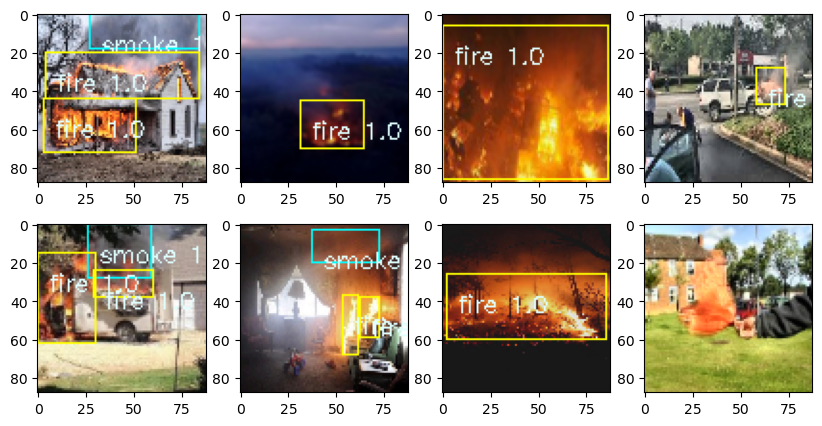

In [14]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):

for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(2,4, figsize=(10, 5))

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(2, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 7):
            break
    #if (idx == 1):
    plt.tight_layout(w_pad=100)
    plt.show()
    break

# Custom Layers

In [15]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

# Apply sigmoid to coords 
class MyLayer_2BB(torch.nn.Module):
    def __init__(self):
        """
        Apply sigmoid to bounding boxes
        """
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        sig = self.sigmoid(x[..., 0:10])
        soft = self.softmax(x[..., 10:12])
        y = torch.concat([sig, soft], dim=-1)
        return y

# Tinyssimo

In [16]:
class Tinyssimo_fixed_88x88_BatchNorm(nn.Module):
    def __init__(self, in_channels=3, num_classes=C):
        super(Tinyssimo_fixed_88x88_BatchNorm, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.tiny_model = self.__create_tinyssimo__()
    
    def __create_tinyssimo__(self):
        tinyssimo_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 1
            nn.Conv2d(self.in_channels, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 2
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 3
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # CNNBlock 4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            # CNNBlock 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # HEAD
            nn.Flatten(),
            #nn.Linear(in_features=128*2*2, out_features=256), # 2 and 2 are dims b4 FC layer
            nn.Linear(in_features=128*2*2, out_features=192), # 2 and 2 are dims b4 FC layer
            nn.ReLU(),
            nn.Dropout(0.8),
            # nn.Linear(in_features=256, 
            #           out_features=SX*SY*(B*5+C)),
            nn.Linear(in_features=192, 
                      out_features=SX*SY*(B*5+C)),
            # Adding Reshape and Sigmoid
            Reshape((-1, 4, 4, 12)),
            MyLayer_2BB(),
            
        )
        return tinyssimo_model 

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        y = self.tiny_model(x)
        return y 

# Yolo Loss 2BB

In [17]:
class YoloLossMSE_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(pred_boxes[..., :2],
                           target_box[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign 
        wh_loss = self.mse(torch.sign(pred_boxes[..., 2:4])*torch.sqrt(torch.abs(pred_boxes[..., 2:4])+1e-6),
                           torch.sqrt(target_box[..., 2:4]))
        #print(f'WH Loss {wh_loss:.6f}')
        self.last_box_wh = wh_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:12],
                              exists_box*ground_truth[..., 5:7]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            5*self.last_box_xy,
            5*self.last_box_wh,
            self.last_obj,
            0.5*self.last_noobj,
            self.last_class
            )

# Train Loop Function

In [18]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}')
    
    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                        predictions=out)
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # update progress bar
        #loop.set_postfix(loss=loss.item())
        #print(f'Partial Train Loss: {loss.item()}')

        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)

    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    #print("\nTRAIN losses")
#     print(f"Mean total loss was {train_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return train_mean_loss_out


# Validation Loop Function

In [19]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                                predictions=out)
        
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
        # update progress bar
        #loop.set_postfix(loss=loss.item())

    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    #print("\nVAL losses")
#     print(f"Mean total loss was {val_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")

    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return val_loss_out

# Hyperparameters and Config

In [20]:
''' ============================
    Hyperparameters and More
============================ '''

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
#WEIGHT_DECAY = 5e-4
WEIGHT_DECAY = 0
EPOCHS = 220
NUM_WORKERS = 2
PIN_MEMORY = True
#LOAD_MODEL = False
#LOAD_MODEL_FILE = "overfit.pth.tar"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

IOU_THRES = 0.5
THRESHOLD = 0.1

''' ============================
    Configuration
============================ '''
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

CELL_SIZE_X = 1/SX
CELL_SIZE_Y = 1/SY


''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

# Main Function

In [21]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    print(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')


    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    
#     print(cell2box_mask)
#     print("\n")

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if IMG_W == 88:
        print("Using Tinyssimo 88x88")
        model_tynss = Tinyssimo_fixed_88x88_BatchNorm(num_classes=C).to(DEVICE)
    elif IMG_W == 224:
        print("Using BED 224x224")
        model_tynss = BIG_BED(num_classes = C,
                          S = SX,
                          B = B,
                          in_channels = 3).to(DEVICE)
    else:
        print("Using Tinyssimo 160x120")
        model_tynss = Tinyssimo_fixed_160x120(num_classes=C).to(DEVICE)
    
    model_tynss._initialize_weights()

    # Check model shape
    in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
    in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
    out_test = model_tynss(in_rand)
    print(f'Model shape is {out_test.shape}')
    print(f'BED Model Arquitecture\n{model_tynss}')
    
    optimizer = optim.Adam(model_tynss.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.9, 
                                                     patience=2, 
                                                     threshold=0.1, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-5)
    
#     optimizer = torch.optim.SGD(model_tynss.parameters(), 
#                                 lr=LEARNING_RATE,
#                                 momentum=0.9, 
#                                 weight_decay=WEIGHT_DECAY, 
#                                 nesterov=True)
    
    n_trainable = sum(p.numel() for p in model_tynss.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(model_tynss.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    
    if B == 1:
        print(f'Using YoloLossMSE')
        loss_fn = YoloLossMSE(SX=SX, 
                              SY=SY, 
                              B=B, 
                              C=C)
    elif B == 2:
        print(f'Using YoloLossMSE_2BBox')
        loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    else:
        print("Wrong B bounding boxes configuration")

    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                                  width= int(1.4*IMG_W),
                                  erosion_rate=0.6,
                                  p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        A.Blur(blur_limit=(3,3), p=0.2),
        A.CLAHE(clip_limit=2.0, p=0.3),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=8*8, 
                                min_visibility=0.05, 
                                label_fields=['class_labels']))
    # TRAIN
    print("\nTRAIN DFIRE dataset")
    train_dataset = DFireDataset(img_h = IMG_H,
                                 img_w = IMG_W,
                                 img_dir = TRAIN_IMG_DIR,
                                 label_dir = TRAIN_LABEL_DIR,
                                 SX = SX,
                                 SY = SY,
                                 C = C,
                                 transform=train_transform)
    
    print("TRAIN DFS dataset")
    train_dfs_dataset = DFSDataset(img_h = IMG_H,
                                   img_w = IMG_W,
                                   img_dir = dfs_images_dir,
                                   labels_list = dfs_train_list,
                                   SX = SX,
                                   SY = SY,
                                   C = C,
                                   transform=train_transform)

    print("Concatenate Train DFire and DFS datasets")
    full_train_ds = torch.utils.data.ConcatDataset((train_dataset, train_dfs_dataset))
    print(f'Train dataset len: {len(full_train_ds)}')

    
    # VALIDATION
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    print("\nTEST DFire dataset")
    eval_dataset = DFireDataset(img_h = IMG_H,
                                img_w = IMG_W,
                                img_dir = EVAL_IMG_DIR,
                                label_dir = EVAL_LABEL_DIR,
                                SX = SX,
                                SY = SY,
                                C = C,
                                transform=val_transform)
    print("TEST DFS dataset")
    test_dfs_dataset = DFSDataset(img_h = IMG_H,
                                  img_w = IMG_W,
                                  img_dir = dfs_images_dir,
                                  labels_list = dfs_test_list,
                                  SX = SX,
                                  SY = SY,
                                  C = C,
                                  transform=val_transform)
    
    print("Concatenate Test DFire and DFS datasets")
    full_test_ds = torch.utils.data.ConcatDataset((eval_dataset, test_dfs_dataset))
    print(f'Test dataset len: {len(full_test_ds)}')
    
    # LOADERS
    train_loader = DataLoader(dataset=full_train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    eval_loader = DataLoader(dataset=full_test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_mAP = -1

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    
    for epoch in range(EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===\n')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=model_tynss, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        
        ##### NO LOGS, ONLY TOTAL LOSS
#         t_loss = train_fn(loader=train_loader, 
#                           model=model_tynss, 
#                           optimizer=optimizer, 
#                           loss_fn=loss_fn,
#                           device=DEVICE)
#         # Appending Train Losses
#         train_total_loss.append(t_loss)


        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=model_tynss,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec:.3f}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=model_tynss,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)
            
            ##### NO LOGS, ONLY TOTAL LOSS
#             v_loss = eval_fn(loader=eval_loader, 
#                              model=model_tynss,                         
#                              loss_fn=loss_fn,
#                              device=DEVICE)
#             # Appending Validation Losses
#             val_total_loss.append(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 5 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=model_tynss,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec:.3f}")

                if best_mAP < mean_avg_prec:
                    best_mAP = mean_avg_prec
                    print(f"\nNew best mAP validation loss: {best_mAP:.3f}")
                    print('Saving best mAP model...')
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model_tynss.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),}, 'tiny_pytorch_results/tiny_best_2BB_mAP.pt')  

        if ( (epoch+1) % 5 ) == 0:
            torch.save(model_tynss.state_dict(), 'tiny_pytorch_results/tiny_2BB_5epoch.pt')
            
        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"New best validation loss: {best_valid_loss:.3f}")
            print('Saving best model...')
            torch.save(model_tynss.state_dict(), 'tiny_pytorch_results/tiny_best_loss_2BB.pt')     
            
    torch.save(model_tynss.state_dict(), 'tiny_pytorch_results/tiny_last_2BB.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')

# Main Execute

In [22]:
if __name__ == "__main__":
    print("Starting script\n")
    #print(torch.cuda.is_available())
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Batch Size: 64
IMG DIMS: (88, 88)
W: 88
H: 88
SX: 4
SY: 4
B: 2
C: 2
Cell size:
	x = 0.25
	y = 0.25
Using Tinyssimo 88x88
Model shape is torch.Size([4, 4, 4, 12])
BED Model Arquitecture
Tinyssimo_fixed_88x88_BatchNorm(
  (tiny_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(16, 32, kernel_size=(3, 3), stri

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(



Trainable parameters = 468880
Total parameters = 468880

Using YoloLossMSE_2BBox

TRAIN DFIRE dataset
Removed wrong images: 0
Removed due to overlapping: 891
Removed due to more than 3: 1764
TRAIN DFS dataset
Removed wrong images: 0
Removed due to overlapping: 838
Removed due to more than 3: 1370
Concatenate Train DFire and DFS datasets
Train dataset len: 20265

TEST DFire dataset
Removed wrong images: 0
Removed due to overlapping: 199
Removed due to more than 3: 445
TEST DFS dataset
Removed wrong images: 0
Removed due to overlapping: 211
Removed due to more than 3: 386
Concatenate Test DFire and DFS datasets
Test dataset len: 5038

***Start Training: 07:32:26


=== EPOCH 0/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:54<00:00,  2.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.725     |48.215      |36.206      |11.318      |15.987      



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.578     |53.117      |42.322      |3.711       |11.428      

New best validation loss: 110.578
Saving best model...

=== EPOCH 1/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.891      |40.890      |35.910      |5.643       |11.448      



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.144     |46.876      |42.191      |3.704       |9.373       

New best validation loss: 102.144
Saving best model...

=== EPOCH 2/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:58<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
89.036      |38.178      |35.066      |5.789       |10.003      



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.577      |44.688      |41.447      |3.516       |8.926       

New best validation loss: 98.577
Saving best model...

=== EPOCH 3/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:54<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
87.027      |37.304      |34.458      |5.972       |9.293       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.692      |42.689      |41.648      |2.907       |8.447       

New best validation loss: 95.692
Saving best model...

=== EPOCH 4/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
85.067      |36.378      |33.895      |5.962       |8.832       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.27it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.997      |41.869      |39.953      |3.918       |8.258       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]



Validation mAP: 0.077

New best mAP validation loss: 0.077
Saving best mAP model...
New best validation loss: 93.997
Saving best model...

=== EPOCH 5/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.288      |35.281      |33.688      |5.948       |8.371       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.525      |39.130      |40.199      |3.529       |7.666       

New best validation loss: 90.525
Saving best model...

=== EPOCH 6/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.343      |34.948      |33.291      |6.019       |8.085       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.291      |39.234      |39.760      |3.377       |7.920       

New best validation loss: 90.291
Saving best model...

=== EPOCH 7/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.030      |34.323      |32.822      |6.014       |7.870       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
88.872      |38.707      |38.490      |3.915       |7.761       

New best validation loss: 88.872
Saving best model...

=== EPOCH 8/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.329      |33.703      |32.769      |5.989       |7.869       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.603      |40.618      |38.039      |4.494       |7.452       


=== EPOCH 9/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.043      |33.091      |32.483      |5.979       |7.490       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.794      |37.099      |38.973      |3.311       |7.411       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]



Validation mAP: 0.118

New best mAP validation loss: 0.118
Saving best mAP model...
New best validation loss: 86.794
Saving best model...

=== EPOCH 10/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.83it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
78.640      |32.937      |32.193      |6.125       |7.384       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
86.384      |37.389      |37.685      |4.188       |7.122       

New best validation loss: 86.384
Saving best model...

=== EPOCH 11/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.83it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.437      |32.326      |31.938      |6.075       |7.098       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.807      |34.408      |39.648      |2.783       |7.968       

New best validation loss: 84.807
Saving best model...

=== EPOCH 12/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.560      |32.424      |31.869      |6.094       |7.172       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
84.799      |36.251      |38.001      |3.399       |7.148       

New best validation loss: 84.799
Saving best model...

=== EPOCH 13/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:54<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
76.038      |31.601      |31.284      |6.146       |7.007       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.851      |34.840      |38.272      |3.442       |7.297       

New best validation loss: 83.851
Saving best model...

=== EPOCH 14/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.73it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.648      |31.418      |31.239      |6.121       |6.870       




mAP:@.5: 100%|██████████| 2/2 [00:12<00:00,  6.33s/it]



Train mAP: 0.173


Validating: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.587      |34.781      |37.883      |3.354       |7.569       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]



Validation mAP: 0.142

New best mAP validation loss: 0.142
Saving best mAP model...
New best validation loss: 83.587
Saving best model...

=== EPOCH 15/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.865      |30.984      |30.836      |6.220       |6.825       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.473      |35.085      |37.752      |3.237       |7.399       

New best validation loss: 83.473
Saving best model...

=== EPOCH 16/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.430      |30.850      |30.729      |6.181       |6.670       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.530      |34.314      |37.341      |3.630       |7.245       

New best validation loss: 82.530
Saving best model...

=== EPOCH 17/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.913      |30.382      |30.503      |6.247       |6.781       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
83.329      |34.007      |37.559      |3.132       |8.632       


=== EPOCH 18/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.83it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.504      |30.074      |30.374      |6.259       |6.797       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.255      |34.293      |36.775      |3.437       |7.749       

New best validation loss: 82.255
Saving best model...

=== EPOCH 19/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.403      |30.002      |30.289      |6.259       |6.852       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.521      |33.183      |36.452      |3.575       |7.310       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]



Validation mAP: 0.163

New best mAP validation loss: 0.163
Saving best mAP model...
New best validation loss: 80.521
Saving best model...

=== EPOCH 20/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.974      |30.125      |29.805      |6.350       |6.694       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
82.150      |34.266      |36.637      |3.320       |7.926       


=== EPOCH 21/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:57<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.556      |29.774      |29.956      |6.255       |6.571       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.899      |32.997      |36.304      |3.540       |7.059       

New best validation loss: 79.899
Saving best model...

=== EPOCH 22/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.138      |29.670      |29.756      |6.186       |6.526       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
80.375      |32.371      |37.463      |2.762       |7.779       


=== EPOCH 23/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.553      |29.339      |29.235      |6.394       |6.585       



Validating: 100%|██████████| 78/78 [00:21<00:00,  3.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.711      |32.576      |35.914      |3.568       |7.653       

New best validation loss: 79.711
Saving best model...

=== EPOCH 24/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.503      |29.391      |29.355      |6.348       |6.409       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
78.145      |32.581      |35.449      |3.515       |6.600       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]



Validation mAP: 0.178

New best mAP validation loss: 0.178
Saving best mAP model...
New best validation loss: 78.145
Saving best model...

=== EPOCH 25/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.088      |29.145      |29.313      |6.186       |6.444       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.553      |33.852      |34.037      |4.669       |6.994       


=== EPOCH 26/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.802      |29.031      |29.068      |6.317       |6.385       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.419      |31.551      |35.483      |3.238       |7.146       

New best validation loss: 77.419
Saving best model...

=== EPOCH 27/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.595      |28.979      |28.999      |6.228       |6.390       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
79.615      |33.804      |34.629      |3.882       |7.299       


=== EPOCH 28/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.605      |28.477      |28.708      |6.202       |6.218       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
76.266      |31.480      |34.022      |4.127       |6.637       

New best validation loss: 76.266
Saving best model...

=== EPOCH 29/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.428      |28.319      |28.758      |6.220       |6.132       




mAP:@.5: 100%|██████████| 2/2 [00:12<00:00,  6.09s/it]



Train mAP: 0.234


Validating: 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
78.453      |31.170      |35.749      |3.006       |8.528       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]



Validation mAP: 0.183

New best mAP validation loss: 0.183
Saving best mAP model...

=== EPOCH 30/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:51<00:00,  2.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.373      |28.300      |28.658      |6.191       |6.224       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.95it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.545      |31.467      |35.494      |3.305       |7.279       


=== EPOCH 31/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 316/316 [01:53<00:00,  2.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
68.933      |28.009      |28.526      |6.324       |6.074       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.155      |31.851      |34.094      |3.737       |7.473       


=== EPOCH 32/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:50<00:00,  2.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
68.258      |27.740      |28.314      |6.239       |5.965       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.365      |31.910      |33.943      |4.027       |7.486       


=== EPOCH 33/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:52<00:00,  2.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
68.519      |27.964      |28.330      |6.283       |5.942       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.692      |30.727      |34.083      |3.732       |7.151       

New best validation loss: 75.692
Saving best model...

=== EPOCH 34/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.971      |27.792      |28.084      |6.291       |5.804       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.31it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.657      |29.928      |35.206      |3.084       |7.439       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]



Validation mAP: 0.201

New best mAP validation loss: 0.201
Saving best mAP model...
New best validation loss: 75.657
Saving best model...

=== EPOCH 35/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:51<00:00,  2.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.536      |27.415      |27.971      |6.257       |5.893       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.392      |30.507      |33.973      |3.497       |7.414       

New best validation loss: 75.392
Saving best model...

=== EPOCH 36/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:55<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.032      |27.238      |27.829      |6.222       |5.744       



Validating: 100%|██████████| 78/78 [00:21<00:00,  3.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
75.019      |29.712      |34.780      |3.252       |7.275       

New best validation loss: 75.019
Saving best model...

=== EPOCH 37/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:52<00:00,  2.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.365      |27.386      |27.817      |6.289       |5.873       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
76.099      |30.232      |34.426      |3.412       |8.029       


=== EPOCH 38/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:56<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.816      |27.302      |27.596      |6.319       |5.599       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.903      |30.669      |33.371      |3.671       |7.192       

New best validation loss: 74.903
Saving best model...

=== EPOCH 39/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:57<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.747      |27.139      |27.846      |6.152       |5.610       



Validating: 100%|██████████| 78/78 [00:21<00:00,  3.59it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.409      |29.592      |33.939      |3.441       |7.437       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]



Validation mAP: 0.222

New best mAP validation loss: 0.222
Saving best mAP model...
New best validation loss: 74.409
Saving best model...

=== EPOCH 40/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [02:04<00:00,  2.53it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.157      |26.910      |27.453      |6.170       |5.624       



Validating: 100%|██████████| 78/78 [00:26<00:00,  2.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.109      |30.353      |33.211      |4.007       |6.538       

New best validation loss: 74.109
Saving best model...

=== EPOCH 41/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [02:01<00:00,  2.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.965      |26.707      |27.409      |6.259       |5.590       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.125      |30.236      |33.078      |3.808       |7.002       


=== EPOCH 42/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:52<00:00,  2.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.474      |27.021      |27.484      |6.211       |5.758       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.256      |30.199      |33.503      |3.571       |6.983       


=== EPOCH 43/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:55<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.115      |26.623      |27.512      |6.278       |5.702       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.424      |28.499      |34.559      |3.042       |7.323       

New best validation loss: 73.424
Saving best model...

=== EPOCH 44/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:54<00:00,  2.76it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.601      |26.523      |27.153      |6.205       |5.720       




mAP:@.5: 100%|██████████| 2/2 [00:12<00:00,  6.22s/it]



Train mAP: 0.275


Validating: 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.763      |29.083      |33.636      |3.344       |6.699       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



Validation mAP: 0.218
New best validation loss: 72.763
Saving best model...

=== EPOCH 45/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:54<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.672      |26.634      |27.183      |6.193       |5.662       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.306      |29.438      |32.915      |3.673       |7.280       


=== EPOCH 46/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:52<00:00,  2.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.124      |26.453      |27.203      |6.132       |5.337       



Validating: 100%|██████████| 78/78 [00:21<00:00,  3.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.566      |30.074      |33.391      |3.536       |7.565       


=== EPOCH 47/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 316/316 [01:54<00:00,  2.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.932      |26.691      |27.215      |6.300       |5.726       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.785      |30.348      |33.013      |3.595       |6.829       


=== EPOCH 48/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:07<00:00,  2.48it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.688      |25.997      |27.072      |6.244       |5.375       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.161      |28.328      |33.811      |3.246       |7.775       


=== EPOCH 49/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:07<00:00,  2.48it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.890      |26.388      |26.872      |6.211       |5.420       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.936      |28.554      |33.424      |3.313       |7.645       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



Validation mAP: 0.216

=== EPOCH 50/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:10<00:00,  2.43it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.316      |26.083      |26.751      |6.137       |5.345       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.792      |29.134      |32.414      |3.946       |6.297       

New best validation loss: 71.792
Saving best model...

=== EPOCH 51/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:12<00:00,  2.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.190      |25.923      |26.812      |6.201       |5.254       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.280      |28.359      |33.101      |3.526       |7.293       


=== EPOCH 52/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:14<00:00,  2.35it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.263      |25.968      |26.699      |6.294       |5.301       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.96it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.190      |30.158      |31.987      |4.076       |6.968       


=== EPOCH 53/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 316/316 [02:08<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.863      |26.401      |26.749      |6.208       |5.505       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.755      |29.107      |33.101      |3.479       |7.068       


=== EPOCH 54/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 316/316 [02:12<00:00,  2.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.816      |25.633      |26.712      |6.052       |5.418       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.973      |29.102      |32.032      |4.062       |6.777       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]



Validation mAP: 0.228

New best mAP validation loss: 0.228
Saving best mAP model...

=== EPOCH 55/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 316/316 [02:06<00:00,  2.51it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.216      |25.404      |26.773      |6.052       |4.987       



Validating: 100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.219      |28.987      |32.791      |3.592       |6.849       


=== EPOCH 56/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 316/316 [02:06<00:00,  2.51it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.173      |25.322      |26.557      |6.102       |5.192       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.710      |28.738      |33.245      |3.293       |7.435       


=== EPOCH 57/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 316/316 [02:02<00:00,  2.57it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.928      |25.343      |26.373      |6.079       |5.132       



Validating: 100%|██████████| 78/78 [00:29<00:00,  2.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.158      |29.160      |32.297      |3.694       |7.007       


=== EPOCH 58/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 316/316 [02:39<00:00,  1.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.771      |25.064      |26.378      |6.105       |5.224       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.51it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.299      |28.703      |32.878      |3.479       |7.239       


=== EPOCH 59/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 316/316 [02:03<00:00,  2.56it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.269      |25.205      |26.129      |6.051       |4.885       




mAP:@.5: 100%|██████████| 2/2 [00:13<00:00,  6.60s/it]



Train mAP: 0.300


Validating: 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.776      |28.551      |32.649      |3.519       |7.058       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]



Validation mAP: 0.221
New best validation loss: 71.776
Saving best model...

=== EPOCH 60/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [02:06<00:00,  2.49it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.096      |24.897      |26.062      |6.168       |4.969       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.815      |28.364      |32.583      |3.444       |7.424       


=== EPOCH 61/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [02:05<00:00,  2.53it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.424      |25.394      |25.937      |6.142       |4.950       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.936      |27.794      |32.917      |3.404       |7.820       


=== EPOCH 62/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [02:01<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.227      |24.882      |26.119      |6.090       |5.136       



Validating: 100%|██████████| 78/78 [00:26<00:00,  3.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.384      |28.460      |32.173      |3.642       |7.109       

New best validation loss: 71.384
Saving best model...

=== EPOCH 63/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [01:57<00:00,  2.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.014      |25.020      |25.761      |6.047       |5.186       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.241      |28.482      |32.168      |3.657       |7.934       


=== EPOCH 64/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [02:03<00:00,  2.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.147      |24.695      |25.507      |6.066       |4.880       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.90it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.249      |28.164      |32.756      |3.482       |7.847       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]



Validation mAP: 0.226

=== EPOCH 65/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 316/316 [02:01<00:00,  2.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.946      |24.887      |25.856      |6.198       |5.006       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.330      |28.569      |31.718      |3.996       |7.047       

New best validation loss: 71.330
Saving best model...

=== EPOCH 66/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [03:37<00:00,  1.45it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.441      |24.760      |25.831      |5.966       |4.885       



Validating: 100%|██████████| 78/78 [00:32<00:00,  2.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.646      |28.409      |32.054      |3.686       |7.497       


=== EPOCH 67/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [02:05<00:00,  2.52it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.053      |24.447      |25.763      |6.041       |4.801       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.93it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.615      |28.033      |32.564      |3.397       |7.621       


=== EPOCH 68/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [02:05<00:00,  2.51it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.316      |24.692      |25.817      |5.905       |4.902       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.505      |27.782      |31.799      |3.980       |6.944       

New best validation loss: 70.505
Saving best model...

=== EPOCH 69/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [01:57<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.020      |24.594      |25.605      |6.022       |4.798       



Validating: 100%|██████████| 78/78 [00:23<00:00,  3.32it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.711      |27.780      |32.313      |3.658       |7.960       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]



Validation mAP: 0.225

=== EPOCH 70/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [02:02<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.697      |24.540      |25.464      |5.986       |4.706       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.685      |27.909      |32.308      |3.716       |7.753       


=== EPOCH 71/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 316/316 [01:59<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.369      |24.410      |25.284      |5.909       |4.766       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.41it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.644      |27.066      |32.237      |3.534       |7.808       


=== EPOCH 72/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 316/316 [02:03<00:00,  2.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.883      |24.452      |25.547      |6.070       |4.814       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.40it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.678      |27.138      |32.150      |3.485       |7.905       


=== EPOCH 73/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 316/316 [01:58<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.307      |24.294      |25.379      |5.967       |4.666       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.973      |27.520      |31.805      |3.828       |7.820       


=== EPOCH 74/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 316/316 [02:23<00:00,  2.20it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.074      |24.192      |25.373      |5.943       |4.565       




mAP:@.5: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]



Train mAP: 0.318


Validating: 100%|██████████| 78/78 [00:38<00:00,  2.01it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.772      |27.589      |31.675      |3.752       |7.755       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]



Validation mAP: 0.235

New best mAP validation loss: 0.235
Saving best mAP model...

=== EPOCH 75/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 316/316 [02:24<00:00,  2.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.222      |24.285      |25.350      |5.997       |4.589       



Validating: 100%|██████████| 78/78 [00:21<00:00,  3.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.827      |27.916      |31.816      |3.684       |7.411       


=== EPOCH 76/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 316/316 [02:02<00:00,  2.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.959      |24.068      |25.398      |5.917       |4.577       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.45it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.744      |27.535      |31.874      |3.702       |7.632       


=== EPOCH 77/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 316/316 [02:01<00:00,  2.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.972      |24.117      |25.227      |5.930       |4.699       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.166      |27.284      |32.249      |3.494       |8.139       


=== EPOCH 78/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 316/316 [02:04<00:00,  2.53it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.927      |24.065      |25.271      |5.983       |4.608       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.469      |27.847      |31.648      |3.659       |7.316       

New best validation loss: 70.469
Saving best model...

=== EPOCH 79/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 316/316 [02:00<00:00,  2.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.934      |24.173      |25.229      |5.909       |4.623       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.487      |27.844      |31.629      |3.662       |7.352       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]



Validation mAP: 0.232

=== EPOCH 80/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 316/316 [02:02<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.555      |24.129      |25.094      |5.825       |4.506       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.577      |28.106      |31.728      |3.710       |8.034       


=== EPOCH 81/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [02:06<00:00,  2.50it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.692      |24.225      |24.772      |5.961       |4.734       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.549      |26.965      |31.779      |3.667       |8.138       


=== EPOCH 82/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [01:55<00:00,  2.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.720      |24.244      |25.051      |5.848       |4.577       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.43it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.729      |27.285      |32.051      |3.404       |7.989       


=== EPOCH 83/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [01:58<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.126      |23.702      |24.950      |5.894       |4.581       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.222      |27.333      |31.341      |3.856       |7.693       

New best validation loss: 70.222
Saving best model...

=== EPOCH 84/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [02:03<00:00,  2.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.989      |23.536      |25.005      |5.981       |4.466       



Validating: 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.462      |27.510      |31.784      |3.481       |7.686       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]



Validation mAP: 0.231

=== EPOCH 85/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [01:59<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.888      |23.669      |24.907      |5.875       |4.437       



Validating: 100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.437      |27.373      |31.509      |3.638       |7.916       


=== EPOCH 86/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 316/316 [02:01<00:00,  2.59it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.514      |23.911      |24.978      |5.921       |4.704       



Validating: 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.721      |28.033      |31.369      |3.838       |7.482       


=== EPOCH 87/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 316/316 [01:58<00:00,  2.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.964      |23.635      |24.983      |5.905       |4.440       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.42it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.742      |27.756      |31.774      |3.541       |7.672       


=== EPOCH 88/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 316/316 [01:55<00:00,  2.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.762      |23.598      |24.846      |5.954       |4.364       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
71.230      |27.552      |31.889      |3.495       |8.293       


=== EPOCH 89/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 316/316 [02:00<00:00,  2.61it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.303      |23.507      |24.632      |5.813       |4.351       




mAP:@.5: 100%|██████████| 2/2 [00:13<00:00,  6.68s/it]



Train mAP: 0.320


Validating: 100%|██████████| 78/78 [00:19<00:00,  3.92it/s]

Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.721      |27.267      |31.151      |3.845       |7.458       




mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]



Validation mAP: 0.241

New best mAP validation loss: 0.241
Saving best mAP model...
New best validation loss: 69.721
Saving best model...

=== EPOCH 90/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 316/316 [02:01<00:00,  2.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.541      |23.402      |24.719      |5.879       |4.541       



Validating: 100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.646      |27.636      |31.331      |3.754       |7.925       


=== EPOCH 91/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 316/316 [01:57<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.252      |23.535      |24.617      |5.746       |4.355       



Validating: 100%|██████████| 78/78 [00:22<00:00,  3.42it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
69.909      |27.520      |31.263      |3.726       |7.400       


=== EPOCH 92/219 ===

Learning Rate = 0.00015690529804500002


Training:  32%|███▏      | 100/316 [00:36<01:17,  2.78it/s]


KeyboardInterrupt: 

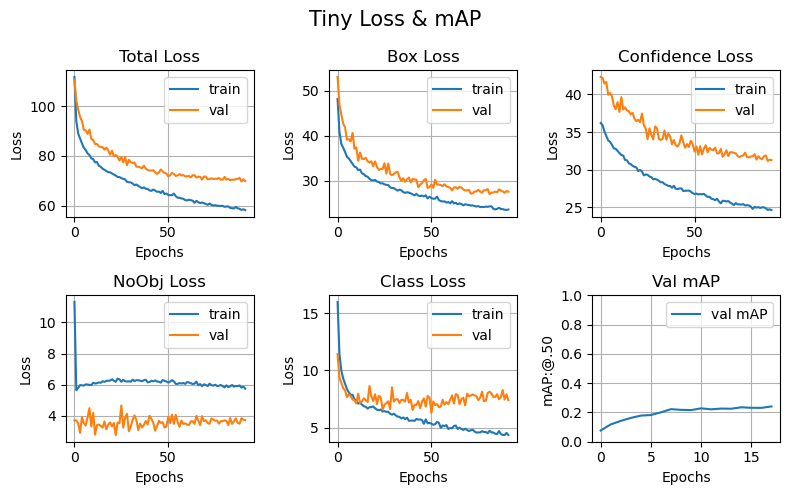

In [23]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(2,3, figsize=(8, 5))
fig.suptitle('Tiny Loss & mAP', fontsize=15)

plt.subplot(2,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.plot(train_box_loss, label="train")
plt.plot(val_box_loss, label="val")
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,4)
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.plot(val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("tiny_pytorch_results/tiny_loss_map.png")
plt.show()

/tmp/ipykernel_2069889/1942273802.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)
/tmp/ipykernel_2069889/1942273802.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


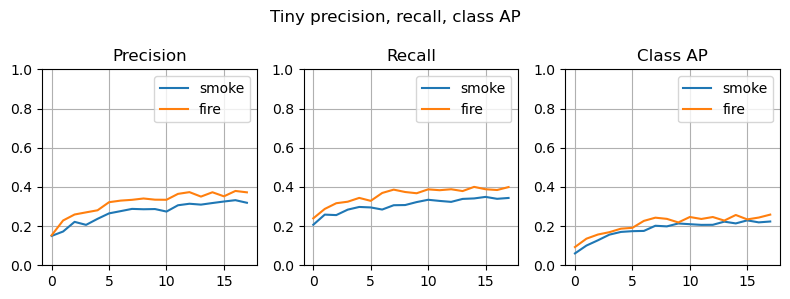

In [24]:
# val_class_AP
# val_class_precision
# val_class_recall

smoke_prec = []
fire_prec = []
for prec in val_class_precision:
    smoke_prec.append(prec[0])
    fire_prec.append(prec[1])

smoke_recall = []
fire_recall = []
for rec in val_class_recall:
    smoke_recall.append(rec[0])
    fire_recall.append(rec[1])

smoke_ap = []
fire_ap = []
for ap in val_class_AP:
    smoke_ap.append(ap[0])
    fire_ap.append(ap[1])

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Tiny precision, recall, class AP')

plt.subplot(1, 3, 1)
plt.plot(smoke_prec, label="smoke")
plt.plot(fire_prec, label="fire")
plt.title("Precision")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(smoke_recall, label="smoke")
plt.plot(fire_recall, label="fire")
plt.title("Recall")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(smoke_ap, label="smoke")
plt.plot(fire_ap, label="fire")
plt.title("Class AP")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig("tiny_pytorch_results/tiny_precision_recall_classAP.png")
plt.show()